# Knowledge Based Position Prediction

We use knowledge graph embeddings to predict the position of a player in league of legends based on the top 5 players

### Presets

In [1]:
import pandas as pd
from node2vec import Node2Vec

import networkx as nx

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from db.graph import Neo4JConnector
from util.graph_tools import visualize_graph

In [2]:
random_state = 4201312
node_color = {"Position": 0, "Champion": 1, "Player": 2}
position_color = {'BOT': "#ee4035", 'SUP': "#f37736", 'JGL': "#fdf498", 'MID': "#7bc043", 'TOP': "#0392cf"}

neo4j = Neo4JConnector.create_from_config("../config.ini")

## Build Graph

From the Neo4J database we select all players (with more than 10 games and a known position) with their preferred champions (<= 5).

We visualize the subgraph for 5 players.  

In [3]:
g = nx.DiGraph()
query = """CALL {
        MATCH (p:Player)-[pi:PLAYS_IN]->(pim:PlayerInMatch)
        WITH p, COUNT(pim.matchID) AS matchesPlayed 
        WHERE matchesPlayed > 10
        RETURN p
    }
    MATCH (p)-[pc:PLAYS_CHAMP]->(c:Champion), (p)-[hp:HAS_POSITION]->(pos:Position)
    RETURN *"""

neo4j.create_graph_from_query(graph=g, query=query)
str(g)

'DiGraph with 9874 nodes and 55779 edges'

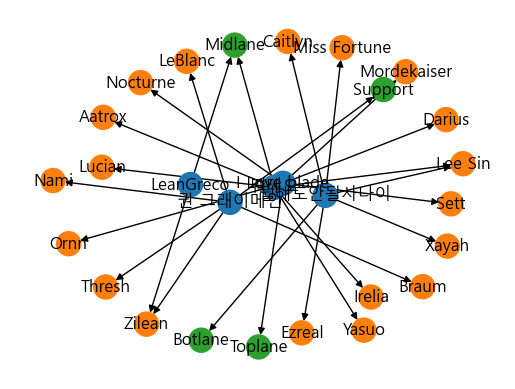

In [4]:
nodes_types = nx.get_node_attributes(g, 'type')
nodes_player = [node for node in nodes_types if nodes_types[node] == "Player"]
nodes_champion = [node for node in nodes_types if nodes_types[node] == "Champion"]
nodes_position = [node for node in nodes_types if nodes_types[node] == "Position"]

subgraph = nx.DiGraph(g.subgraph(nodes_champion + nodes_position + nodes_player[:5]))
subgraph.remove_nodes_from([node for node, degree in dict(subgraph.degree()).items() if degree == 0])
visualize_graph(subgraph)

## Train-/ Test-Splits

In order to generate the train and test set we build a dataframe from the positions of the players. 
Then we create a train and test set with a (90%, 10%) split. 
To avoid data leakage, we remove the test-set edges from the graph. 

In [5]:
node_infos = nx.get_node_attributes(g, "properties")

df_positions = nx.to_pandas_edgelist(g)
df_positions = df_positions[df_positions["type"] == "HAS_POSITION"]
df_positions["target_info"] = df_positions.target.apply(lambda x: node_infos[x])
df_positions["source_info"] = df_positions.source.apply(lambda x: node_infos[x])
df_positions.head()

,source,target,properties,type,target_info,source_info
0,4:abbe0952-2458-485b-a26a-9f3828f2c994:12,4:abbe0952-2458-485b-a26a-9f3828f2c994:1833124,{'winningRate': 6.0},HAS_POSITION,"{'positionID': 'BOT', 'name': 'Botlane'}",{'accountID': 'v17WAJ1uDcAGWOvjr3E8erH354m04nJ...
6,4:abbe0952-2458-485b-a26a-9f3828f2c994:15,4:abbe0952-2458-485b-a26a-9f3828f2c994:1833122,{'winningRate': 0.6},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'vhxgfZVnErOfzYQ7wjeaFh1K6nR2j5-...
8,4:abbe0952-2458-485b-a26a-9f3828f2c994:16,4:abbe0952-2458-485b-a26a-9f3828f2c994:1833122,{'winningRate': 0.46153846153846156},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'n4ZSOu3j2z9htU0PITMyRWTebtXB2pr...
14,4:abbe0952-2458-485b-a26a-9f3828f2c994:17,4:abbe0952-2458-485b-a26a-9f3828f2c994:1833121,{'winningRate': 0.5},HAS_POSITION,"{'positionID': 'TOP', 'name': 'Toplane'}",{'accountID': 'nxKHRVKnmey3-mgzewMr4I8BKG8Gqup...
20,4:abbe0952-2458-485b-a26a-9f3828f2c994:18,4:abbe0952-2458-485b-a26a-9f3828f2c994:1833123,{'winningRate': 0.4375},HAS_POSITION,"{'positionID': 'SUP', 'name': 'Support'}",{'accountID': 'N40gE4B6zp4-fxqZEqq9misaD4HXVdV...


In [6]:
edges_train, edges_test = train_test_split(df_positions, test_size=0.1, random_state=random_state)
f"Size Train {len(edges_train)}, Size Test: {len(edges_test)}"

'Size Train 8748, Size Test: 973'

In [7]:
g_train = g.copy()
g_train.remove_edges_from(edges_test[["source", "target"]].values)

In [8]:
# Mapping for position nodes: nodeID -> positionName
position_map = {x: i for i,x in enumerate(df_positions["target"].unique())}
position_names = {x: g.nodes[x]["properties"]["positionID"] for x in position_map.keys()}

## Node2Vec on train set  

Then we can create the node embeddings using Node2Vec.  

In [9]:
node2vec = Node2Vec(g_train, dimensions=32, walk_length=30, num_walks=100, workers=4)
modeln2v = node2vec.fit(window=5, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/9874 [00:00<?, ?it/s]

## Prediction and Evaluation

In order to predict a players position, we identify the top-10 most similar players (according to the embeddings) and perform a weighted majority voting to predict the player's role. 

Afterwards, we evaluate predict the position for every player in the test set and evaluate the results.

In [10]:
y, y_hat = [], []
for i, test_node in edges_test.iterrows():
    similar_nodes = modeln2v.wv.most_similar(test_node["source"], topn=30)
    neighbor_position = []
    for similar_node in similar_nodes:
        a = edges_train[edges_train["source"] == similar_node[0]]
        if a.size == 0:
            continue
        neighbor_position.append((a["target"].values[0], similar_node[1]))
    

    if len(neighbor_position) > 0:
        nps = {}
        for np, sim in neighbor_position[:10]:
            nps[np] = nps.get(np, 0) + sim
        pred_position = max(nps, key=nps.get)
        
        y.append(position_names[test_node["target"]])   
        y_hat.append(position_names[pred_position])
    else:
        print("err")

print(classification_report(y, y_hat))

              precision    recall  f1-score   support

         BOT       0.92      0.91      0.92       185
         JGL       0.85      0.92      0.88       167
         MID       0.84      0.83      0.84       173
         SUP       0.88      0.78      0.83       295
         TOP       0.80      0.93      0.86       153

    accuracy                           0.86       973
   macro avg       0.86      0.87      0.86       973
weighted avg       0.86      0.86      0.86       973


### Visualize Embeddings

Now we project the player embeddings (n-dimensional vector space) on a 2-dimensional space, in oder to visualize the results. We color coded the players positions so one can see if the embeddings work to categorize them properly. 

In [11]:
pca = PCA(n_components=2)
edges_train["vec"] = edges_train["source"].apply(lambda x: modeln2v.wv.get_vector(x)) 
pca_out = pca.fit_transform(list(edges_train["vec"])) 

edges_train["pca_0"] = pca_out[:, 0]
edges_train["pca_1"] = pca_out[:, 1]

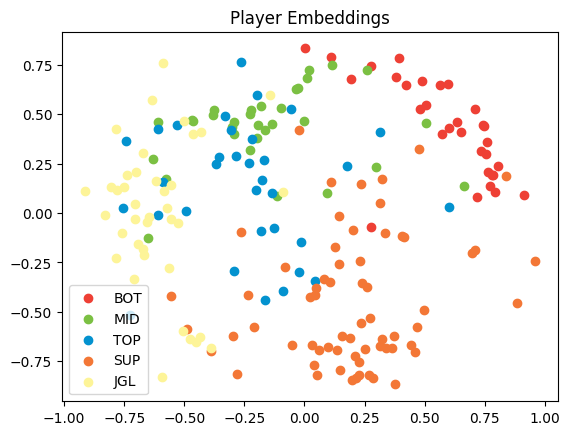

In [12]:
positions_reduced = edges_train.head(200)

for position in position_names:
    player_position = positions_reduced[positions_reduced["target"] == position]
    position_name = position_names[position]
    color = position_color[position_name]
    plt.scatter(player_position["pca_0"], player_position["pca_1"], color=color, label=position_name)

plt.legend()
plt.title("Player Embeddings")
plt.savefig("../img/kn_embedding.png")
plt.show()